# Quick Start

This section offers a brief and quick guide to using PetroFit. It also offers some basic tips on how to use the tools in Photutils and Astropy. For detailed descriptions and workflows, please visit the sections (or Photutils/Astropy documentation) on the topic you are interested in.

## Loading Example Data

The following data is a cutout of a group of bright galaxies in Abell 2744 (located at `(3.596248, -30.388517)`). The original data was acquired by the [Hubble Frontier Fields](https://frontierfields.org) team via the WFC3 instrument in the `F105W` filter and can be directly downloaded from the [Mikulski Archive for Space Telescopes](https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0/hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz.fits). The cutout image used in this documentation can be found in the git repository at the following path `petrofit/docs/data/abell_2744_dwarf_galaxy_f105w.fits.gz`.

### Loading Image 
You can use `astropy`'s ``CCDData`` to load the example data and visualize it through `matplotlib`. Note that ``CCDData.read`` does not return a 2D array, but rather a ``CCDData`` instance which contains the image array, header, and WCS. To access the image array stored in the ``CCDData`` use the ``data`` attribute (i.e ``CCDData.data`` as shown in the ``plt.imshow`` command below).

In [1]:
from astropy.nddata import CCDData

image = CCDData.read('data/abell_2744_dwarf_galaxy_f105w.fits.gz')

In [2]:
# Hidden cell

%matplotlib inline

# Stop Fit Model to Data section warnings
import warnings
warnings.filterwarnings('ignore', append=True)

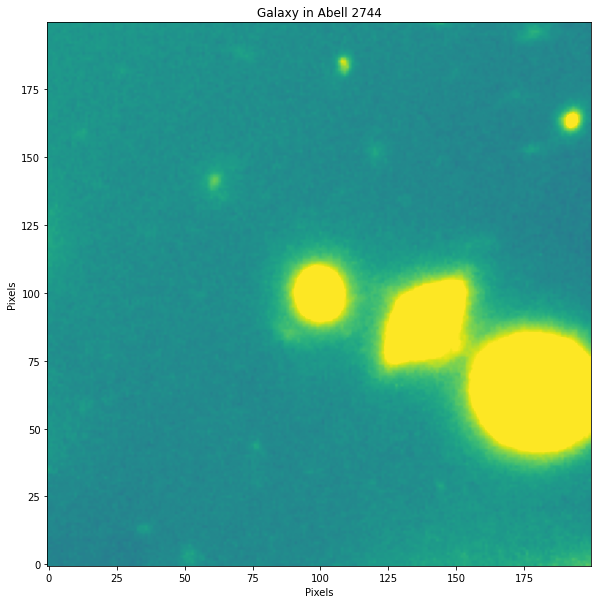

In [3]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'

vmax = 0.05 # vmax for matplotlib imshow
vmin = - vmax 

plt.imshow(image.data, vmin=vmin, vmax=vmax)
plt.title("Galaxy in Abell 2744")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

### Loading RMS 
Since we only want the rms image array, we use `astropy`'s ``io.fits.getdata`` function as follows:

In [4]:
from astropy.io import fits 
rms = fits.getdata('data/abell_2744_dwarf_galaxy_f105w_rms.fits.gz')

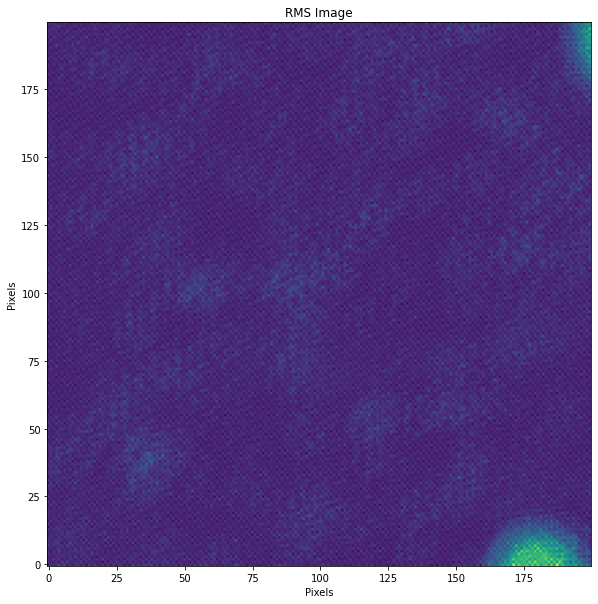

In [5]:
plt.imshow(rms)
plt.title("RMS Image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

### Making Cutouts

You can use `astropy`'s `Cutout2D` function to make cutouts of sources. To access the data (image array), use the ``data`` attribute (i.e ``Cutout2D.data`` as shown in the ``plt.imshow`` command below). Note that ``position`` can be a `SkyCoord` if you provide the `Cutout2D` function a WCS.

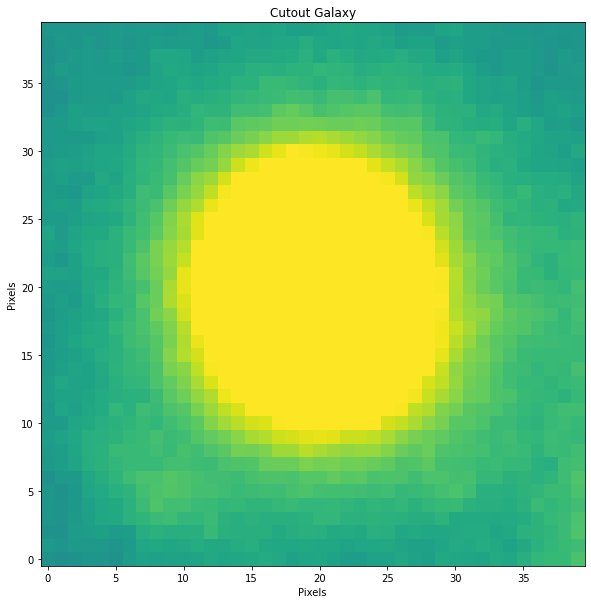

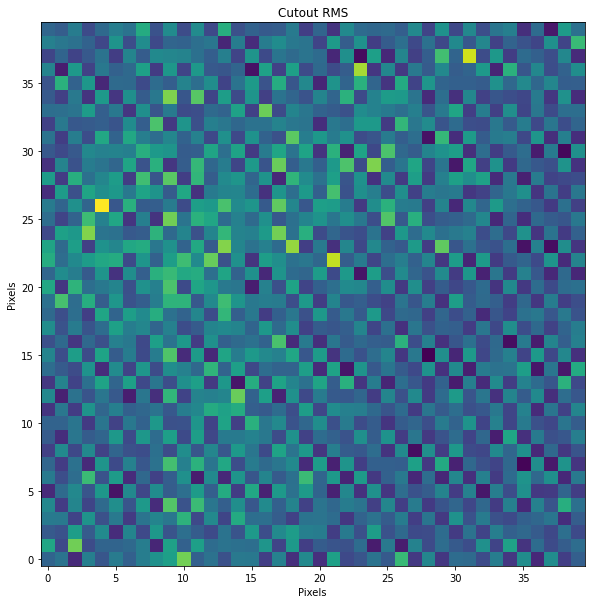

In [6]:
from astropy.nddata import Cutout2D

# Make cutout image, centerd at (100, 100) pixels, 40 pixels in size
cutout_image = Cutout2D(image, position=(100,100), size=40)

# Make cutout rms, centerd at (100, 100) pixels, 40 pixels in size
cutout_rms = Cutout2D(rms, position=(100,100), size=40)

# Plot cutouts
# ------------
plt.imshow(cutout_image.data, vmin=vmin, vmax=vmax)
plt.title("Cutout Galaxy")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

plt.imshow(cutout_rms.data)
plt.title("Cutout RMS")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

## Defining AstroPy Sérsic Models

This example shows how to define a 2D Sérsic model using `astropy`. We fill in our initial guess for the parameters (or correct parameters if we know them) when initializing the ``Sersic2D`` object. 

PetroFit provides a helper function `get_default_sersic_bounds`, which returns a Python dictionary with default parameter bounds. This is useful when fitting because it is used to constrain the fitting parameter space. The `get_default_sersic_bounds` function returns the Python dictionary below. The keys of the dictionary are parameter names and the values are tuples representing the min and max range of the parameter (N.B min or max values are set to `None` if boundless).

```
# get_default_sersic_bounds returns:

bounds = {
    'amplitude': (0., None),
    'r_eff': (0, None),
    'n': (0, 10),
    'ellip': (0, 1),
    'theta': (-2 * np.pi, 2 * np.pi),
}
```

In [7]:
from astropy.modeling import models
from petrofit.modeling import get_default_sersic_bounds

sersic_model = models.Sersic2D(

        amplitude=10, # Intensity at r_eff
        r_eff=1, # Effective or half-lilght radius
        n=4, # Sersic index
        x_0=20, # center of model in the x direction
        y_0=20, # center of model in the y direction
        ellip=0.1, # Ellipticity
        theta=0.0, # Rotation angle in radians, counterclockwise from the positive x-axis.
    
        bounds=get_default_sersic_bounds(), # Parameter bounds
)

To add `x_0` and `y_0` bounds to the default bounds, you can update the dictionary as you would a regular Python dictionary. You can add or update bounds by passing a Python dictionary to the `get_default_sersic_bounds` function as follows:

In [8]:
bound_dict = get_default_sersic_bounds( {'x_0': (10, 30),  
                                         'y_0': (10, 30)} )
bound_dict

{'amplitude': (0.0, None),
 'r_eff': (0.001, None),
 'n': (0.1, 10),
 'ellip': (0, 0.99),
 'theta': (-6.283185307179586, 6.283185307179586),
 'x_0': (10, 30),
 'y_0': (10, 30)}

You can also directly update the model bounds as follows:

In [9]:
sersic_model.bounds.update({'x_0': (10, 30),  'y_0': (10, 30)})

## Making Compound Models (Combining Models)

You can combine multiple models to form a compound model by adding, subtracting, multiplying, and dividing individual models. For example, we add the Sérsic model from the last section to itself to form a two-component Sérsic model (notice that the number of parameters double):

In [10]:
compound_sersic_model = sersic_model + sersic_model

In [11]:
from petrofit.modeling import print_model_params

print_model_params(compound_sersic_model)

10.0000	amplitude_0
1.0000	r_eff_0
4.0000	n_0
20.0000	x_0_0
20.0000	y_0_0
0.1000	ellip_0
0.0000	theta_0
10.0000	amplitude_1
1.0000	r_eff_1
4.0000	n_1
20.0000	x_0_1
20.0000	y_0_1
0.1000	ellip_1
0.0000	theta_1


## Making a PSF Convolved Model 

The `petrofit` `PSFConvolvedModel2D` is a `Fittable2DModel` that adds PSF convolution and model to image sampling to `astropy` core models. `PSFConvolvedModel2D` makes an image of the underlying model and samples it onto a grid. The model image is then convolved with a PSF if one is provided. Since `PSFConvolvedModel2D` is a `Fittable2DModel`, it can be used to fit model images to data images. For example, we wrap an `astropy` `Sersic2D` model in this doc with  `PSFConvolvedModel2D`, which produces an oversampled and PSF convolved version of the Sersic profile at each iteration of the Levenberg-Marquardt fitting algorithm. **Note that `PSFModel` is deprecated and replaced by `PSFConvolvedModel2D`.**

PSF Shape = (49, 49)


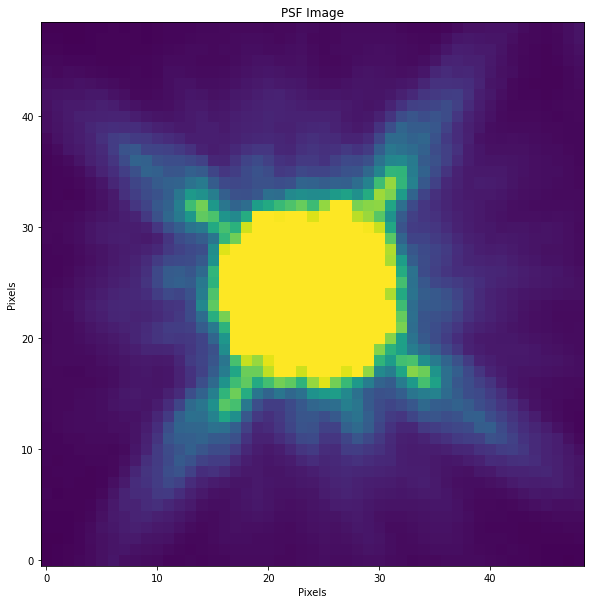

In [12]:
############
# Load PSF #
############

from astropy.io import fits

# Load PSF image (2D array)
PSF = fits.getdata('data/f105w_psf.fits.gz')
PSF = PSF[:-1,:-1]
# Normalize PSF 
PSF = PSF / PSF.sum()

# Note that the PSF shape is odd on all sides
print("PSF Shape = {}".format(PSF.shape))

# Plot PSF and use vmax and vmin to show difraction spikes
plt.imshow(PSF, vmin=0, vmax=PSF.std()/10)
plt.title("PSF Image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

In [13]:
#######################
# PSFConvolvedModel2D #
#######################

from petrofit.modeling import PSFConvolvedModel2D

psf_sersic_model = PSFConvolvedModel2D(sersic_model, psf=PSF, oversample=4)

## Converting Models to Images

To convert any 2D model (Astropy or PetroFit) to an image use the `model_to_image` function.

In [14]:
from petrofit.modeling import model_to_image

# Size of model image
size = 40

# sersic model image
model_image = model_to_image(model=sersic_model, size=size)

# PSF convolved model image 
psf_model_image = model_to_image(model=psf_sersic_model, size=size)

Plot model image

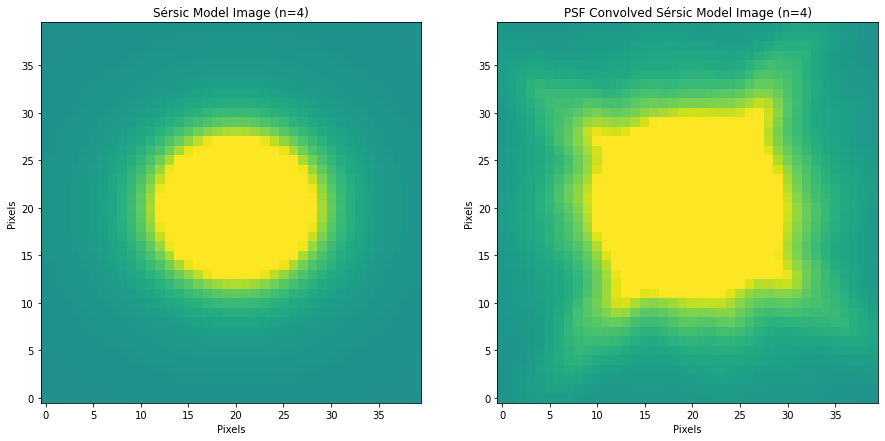

In [15]:
fig, axs = plt.subplots(1,2, figsize=(15,7.5))

plt.sca(axs[0])
plt.imshow(model_image, vmin=vmin, vmax=vmax)
plt.title('Sérsic Model Image (n=4)')
plt.xlabel("Pixels")
plt.ylabel("Pixels")

plt.sca(axs[1])
plt.imshow(psf_model_image, vmin=vmin, vmax=vmax)
plt.title('PSF Convolved Sérsic Model Image (n=4)')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

## Fitting Model to Image

We first define a model with initial guesses as follows:

In [27]:
sersic_model = models.Sersic2D(

        amplitude=0.1, # Intensity at r_eff
        r_eff=10, # Effective or half-lilght radius
        n=1.4, # Sersic index
        x_0=20, # center of model in the x direction
        y_0=20, # center of model in the y direction
        ellip=0.1, # Ellipticity
        theta=0.0, # Rotation angle in radians, counterclockwise from the positive x-axis.
    
        bounds=get_default_sersic_bounds({'x_0': (10, 30),  'y_0': (10, 30)}), # Parameter bounds
)

psf_sersic_model = PSFConvolvedModel2D(sersic_model, psf=PSF, oversample=4)

Before we fit the image, we compute the weights of each pixel using rms data as follows (please note that weights are optional and set to `None` by default):

In [28]:
fitting_weights = 1 / cutout_rms.data 

Use the `fit_model` function to fit 2D models to images as follows:

In [29]:
%%time

from petrofit.modeling import fit_model

fitted_model, fitter = fit_model(
    image=cutout_image.data, 
    model=psf_sersic_model,
    weights=fitting_weights, 
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

CPU times: user 183 ms, sys: 845 µs, total: 184 ms
Wall time: 180 ms


In [30]:
fitted_model

<PSFConvolvedModel2D(amplitude=0.07837347, r_eff=7.64552037, n=1.73795686, x_0=19.89729556, y_0=19.41222907, ellip=0., theta=-0.2112945, psf_pa=-0.36179316)>

Convert the fitted model into an image

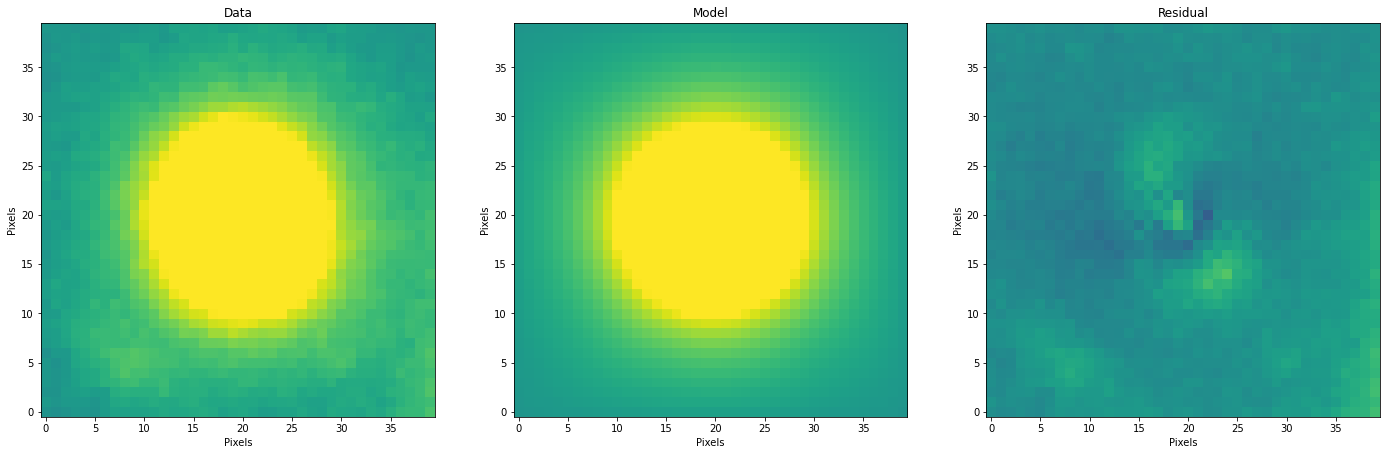

In [31]:
from petrofit.modeling import plot_fit

axs, model_image, residual_image = plot_fit(fitted_model, cutout_image, return_images=True,
                                            vmax=vmax, vmin=vmin, figsize=[24, 12])

for ax in axs:
    ax.set_xlabel('Pixels')
    ax.set_ylabel('Pixels')
    
plt.show()

## Fitting Multiple Sources

If the locations of the sources are known, one can fit all sources at the same time by creating a compound model. Note that `x_0` and `y_0` are known beforehand using photometric centroids. Below, a compound model of 3 Sérsic components is defined and the original image is fit (i.e not the cutout we have been working with).

In [21]:
# Center elliptical galaxy we have been fitting:
galaxy_model_1 = models.Sersic2D(

        amplitude=0.1, # Intensity at r_eff
        r_eff=10, # Effective or half-lilght radius
        n=1.7384901, # Sersic index
        x_0=99.97722657736085, # center of model in the x direction
        y_0=99.12324178530918, # center of model in the y direction
        ellip=0.1, # Ellipticity
        theta=0.0, # Rotation angle in radians, counterclockwise from the positive x-axis.

        bounds=get_default_sersic_bounds(), # Parameter bounds
) 

# Football shaped galaxy 
galaxy_model_2 = models.Sersic2D(

        amplitude=0.1, # Intensity at r_eff
        r_eff=5, # Effective or half-lilght radius
        n=1.2, # Sersic index
        x_0=138.56315299695075, # center of model in the x direction
        y_0=89.27757468116197, # center of model in the y direction
        ellip=0.7, # Ellipticity
        theta=0.7, # Rotation angle in radians, counterclockwise from the positive x-axis.

        bounds=get_default_sersic_bounds(), # Parameter bounds
)

# Large galaxy near the bottom corner 
galaxy_model_3 = models.Sersic2D(

        amplitude=0.1, # Intensity at r_eff
        r_eff=10, # Effective or half-lilght radius
        n=1, # Sersic index
        x_0=178.72302596615611, # center of model in the x direction
        y_0=63.506754312433046	, # center of model in the y direction
        ellip=0.2, # Ellipticity
        theta=0.0, # Rotation angle in radians, counterclockwise from the positive x-axis.

        bounds=get_default_sersic_bounds(), # Parameter bounds
) 

Make compound PSF model as follows:

In [22]:
all_galaxies_model = galaxy_model_1 + galaxy_model_2 + galaxy_model_3

all_galaxies_psf_model = PSFConvolvedModel2D(all_galaxies_model, psf=PSF, oversample=5)

Fit the model 

In [32]:
%%time

from petrofit.modeling import fit_model

all_galaxies_fitted_model, fitter = fit_model(
    image=image.data, 
    model=all_galaxies_psf_model,
    weights=1/rms, # optional 
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

CPU times: user 57.6 s, sys: 4.16 s, total: 1min 1s
Wall time: 1min 1s


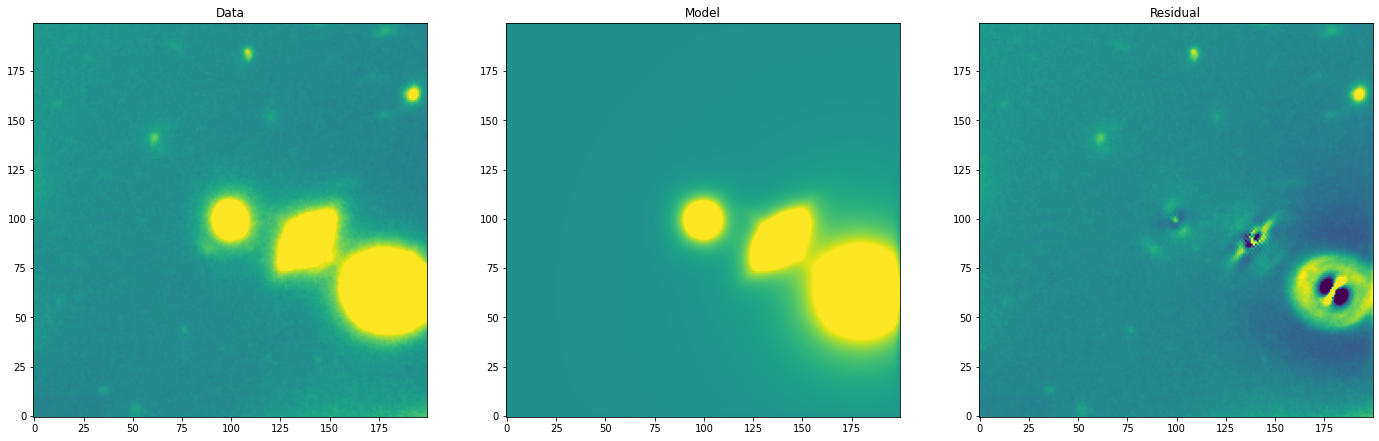

In [33]:
plot_fit(all_galaxies_fitted_model, image, return_images=False,
         vmax=vmax, vmin=vmin, figsize=[24, 12])
plt.show()

Looks like the bottom corner galaxy is a spiral, let us add another component for the spiral and fit again:

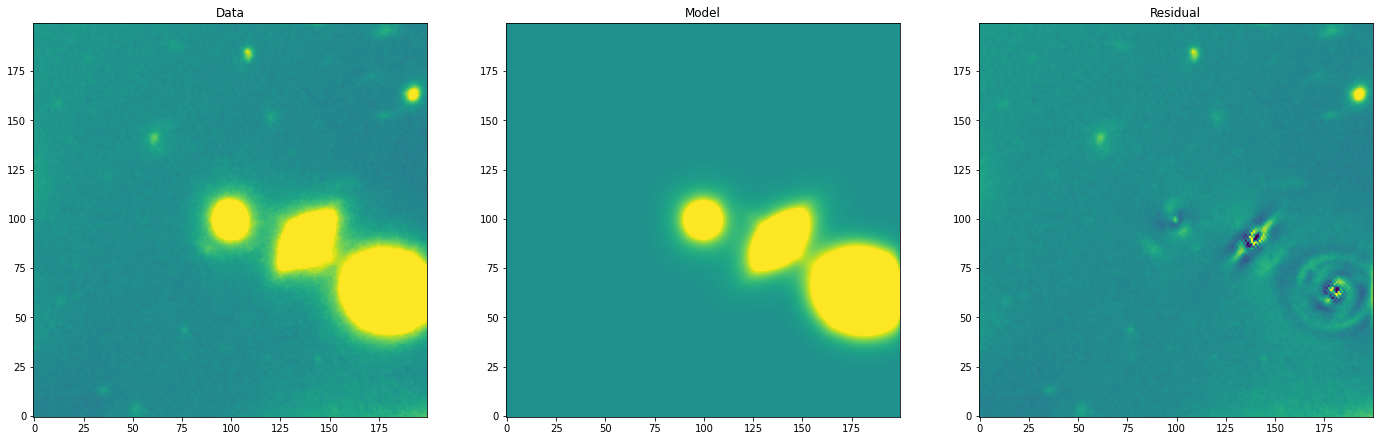

CPU times: user 13.6 s, sys: 108 ms, total: 13.7 s
Wall time: 13.5 s


In [34]:
%%time

# Redefine model with an extra component for galaxy 3 
all_galaxies_model = galaxy_model_1 + galaxy_model_2 + galaxy_model_3.copy() + galaxy_model_3.copy()

# PSF model
all_galaxies_psf_model = PSFConvolvedModel2D(all_galaxies_model, psf=PSF, oversample=1)

# Fit the model
all_galaxies_fitted_model, fitter = fit_model(
    image=image.data, 
    model=all_galaxies_psf_model,
    weights=1/rms, # optional
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

# Plot the fit
plot_fit(all_galaxies_fitted_model, image, return_images=False,
         vmax=vmax, vmin=vmin, figsize=[24, 12])
plt.show()

In [35]:
all_galaxies_fitted_model

<PSFConvolvedModel2D(amplitude_0=0.09798872, r_eff_0=6.75974697, n_0=1.48012358, x_0_0=99.88168804, y_0_0=99.40433847, ellip_0=0., theta_0=6.28318531, amplitude_1=0.92140402, r_eff_1=5.53762487, n_1=2.23867699, x_0_1=138.83850412, y_0_1=89.21656027, ellip_1=0.48375241, theta_1=0.79351986, amplitude_2=0.16085617, r_eff_2=15.46974108, n_2=0.43686621, x_0_2=180.22654997, y_0_2=63.33894513, ellip_2=0.15678919, theta_2=-0.29775418, amplitude_3=1.14847041, r_eff_3=3.52097364, n_3=1.96088738, x_0_3=180.13559279, y_0_3=63.25118697, ellip_3=0.26638482, theta_3=0.99092903, psf_pa=1.85524)>

## Fitting Image Backgrounds 

The `fit_background` function can be used to fit the background pixels using a 2D plane. It will sigma clip the pixels (sigma value provided by the user) and fit a 2D plane to the clipped image. Users can also provide their own 2D models.

In [26]:
from petrofit.modeling import fit_background

In [27]:
bg_model, fitter = fit_background(image, sigma=3.0)
bg_image = model_to_image(bg_model, size=(image.shape[1], image.shape[0]))

Plot backround

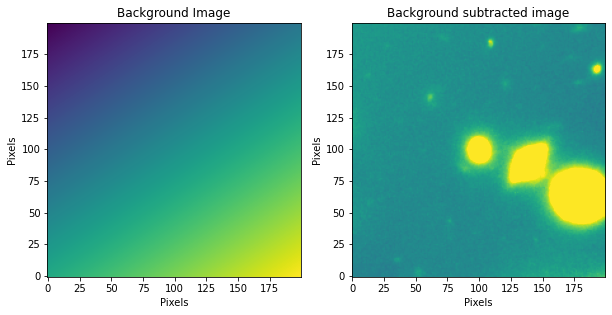

In [28]:
fig, axs = plt.subplots(1,2)

plt.sca(axs[0])
plt.imshow(bg_image)
plt.title("Background Image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

plt.sca(axs[1])
plt.imshow(image.data - bg_image, vmin=vmin, vmax=vmax)
plt.title("Background subtracted image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

## Fitting a PSF With a Moffat Model

In this example we fit the PSF itself, from [the section above](#Making-a-PSF-Convolved-Model), using an `astropy` 2D Moffat model (PSF convolution is not needed for such fits). We then use the model PSF to fit the cutout image from the [Making Cutouts section](#Making-Cutouts). We start by initializing a `Moffat2D` model:

In [29]:
moffat_model = models.Moffat2D(amplitude=1, x_0=25, y_0=25, gamma=1, alpha=1)

Fit the model using ``fit_model``:

In [30]:
%%time

fitted_moffat_model, fitter = fit_model(
    image=PSF, 
    model=moffat_model,
    weights=None, # optional 
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

CPU times: user 10.4 ms, sys: 43 µs, total: 10.4 ms
Wall time: 8.77 ms


Plot the fit and print out fitted parameters:

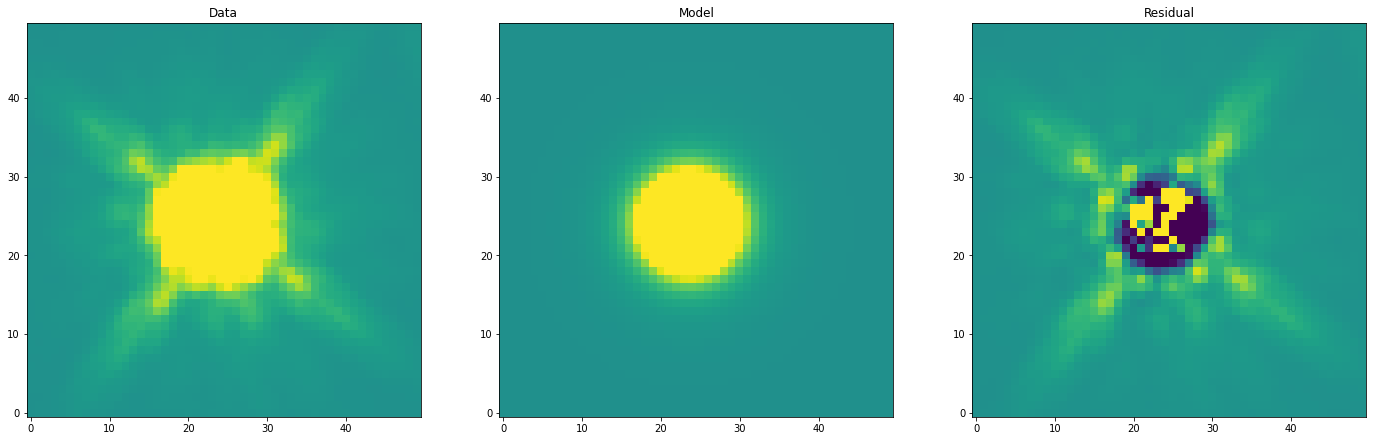

Fitted Moffat Params:
0.0780	amplitude
23.6932	x_0
24.0988	y_0
2.2447	gamma
2.3227	alpha


In [31]:
psf_vmax = PSF.std()/10
psf_vmin = -psf_vmax
plot_fit(fitted_moffat_model, PSF, vmin=psf_vmin, vmax=psf_vmax, figsize=[24, 12])
plt.show()

print("Fitted Moffat Params:")
print_model_params(fitted_moffat_model)

Use the fitted Moffat model as a PSF and fit a galaxy:

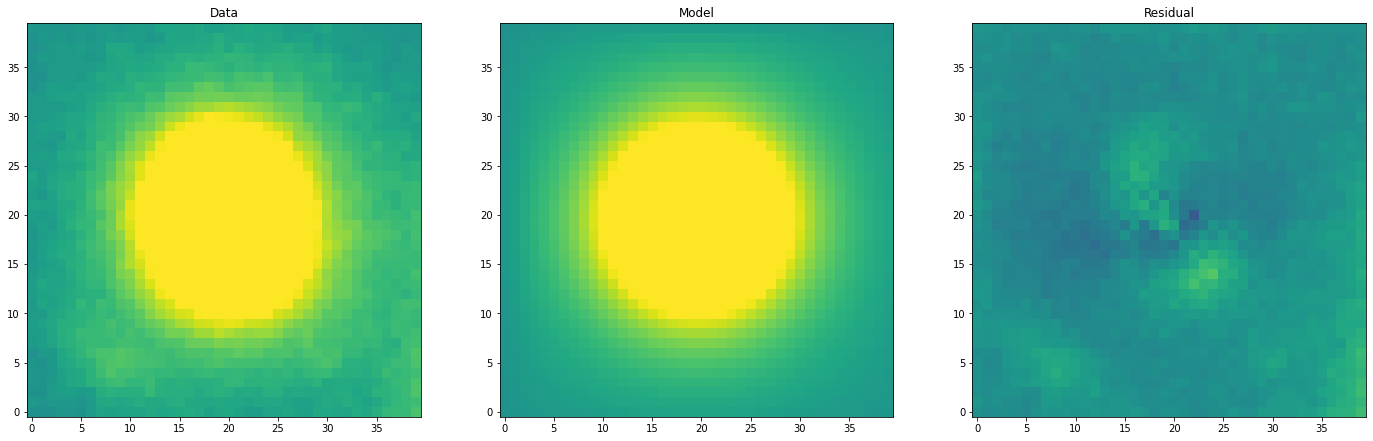

In [32]:
# Make Moffat PSF 
moffat_model_psf = model_to_image(fitted_moffat_model, size=(51, 51))

# Make a PSFConvolvedModel2D model with Moffat PSF 
moffat_psf_sersic_model = PSFConvolvedModel2D(
    sersic_model, 
    psf=moffat_model_psf, # Moffat PSF 
    oversample=4
)

# Fit the galaxy cutout image
fitted_moffat_psf_sersic_model, fitter = fit_model(
    image=cutout_image.data, 
    model=moffat_psf_sersic_model,
    weights=fitting_weights, # optional 
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

plot_fit(fitted_moffat_psf_sersic_model, cutout_image.data, vmin=vmin, vmax=vmax, figsize=[24, 12])

## Making a Photutils Source Catalog

To make a Photutils source catalog, which can also be converted into a table, use the `make_catalog` wrapper as follows:

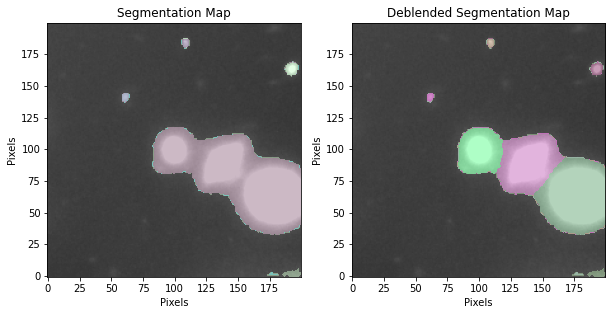

In [33]:
from petrofit.segmentation import make_catalog, plot_segments
from astropy.stats import sigma_clipped_stats

# Sigma clipped stats
image_mean, image_median, image_stddev = sigma_clipped_stats(image.data, sigma=3)

cat, segm, segm_deblend = make_catalog(
    image=image.data,  # Input image
    threshold=image_stddev*3,  # Detection threshold
    deblend=True,  # Deblend sources?
    kernel_size=3,  # Smoothing kernel size in pixels
    fwhm=3,  # FWHM in pixels
    npixels=4**2,  # Minimum number of pixels that make up a source
    plot=True, vmax=vmax, vmin=vmin # Plotting params
)

Display sources catalog as table:

In [34]:
cat.to_table()

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,192.918274091662,2.0141104413128668,None,184,199,0,6,73.0,4.059218959894892,1.51274149514141,4.573733308635419,0.9279646938023087,0.009197652339935303,0.02371048368513584,0.0,1.079979362897575,nan,3.270188279695567,nan
2,177.58415925312164,1.6049708579663586,None,173,182,1,3,19.0,2.4128066644350166,0.6652011253765318,-0.6658922197554297,0.9612448805237657,0.009142090566456318,0.013734133914113045,0.0,0.21102124266326427,nan,2.4873589470681665,nan
3,61.17365369961398,141.00116334754915,None,59,64,137,144,37.0,1.8397934590700944,1.3411527129881553,71.62290665463276,0.6845465268914117,0.009391779080033302,0.026845833286643028,0.0,0.6124230362474918,nan,1.8546064728864318,nan
4,192.3580846748689,163.3996312195041,None,187,197,158,169,90.0,2.3040018301603666,2.044773697884348,55.905497428428134,0.46083105830884313,0.008794508874416351,0.0929785966873169,0.0,2.9120178716257215,nan,3.2742074725713755,nan
5,108.66793260499497,183.90049157806442,None,106,111,180,187,39.0,1.7989114800444517,1.302978071795277,-85.44730446567772,0.6894694923617852,0.008675895631313324,0.045437149703502655,0.0,0.8557351296767592,nan,1.070700521959084,nan
6,178.711257217933,63.49228593950467,None,142,199,33,94,2716.0,9.420031411435273,9.186448645038533,-41.922724970930275,0.2213095518496971,0.00831806380301714,3.6771397590637207,0.0,422.01793033163995,nan,422.8623354271193,nan
7,138.56653500367548,89.2886186705602,None,113,167,64,112,1843.0,7.523736362982759,5.498617595660491,43.8970823698904,0.6825530754988071,0.008136429823935032,3.6545557975769043,0.0,243.90444730501622,nan,240.21781130318425,nan
8,99.97230291527688,99.12375893226742,None,83,118,81,117,1118.0,6.742586627908717,6.401222934668353,80.14487729404904,0.3141541190688393,0.008563084527850151,0.44580602645874023,0.0,56.82248083688319,nan,60.391903621811416,nan


## Curve of Growth and Petrosian Radii

This step in detailed in the [Photometry](./photometry_and_petrosian.ipynb#Photometry) and [Petrosian](./photometry_and_petrosian.ipynb#Petrosian) sections but we will do a simple example here. The first step is to pick a source from the catalog we made in the last step:

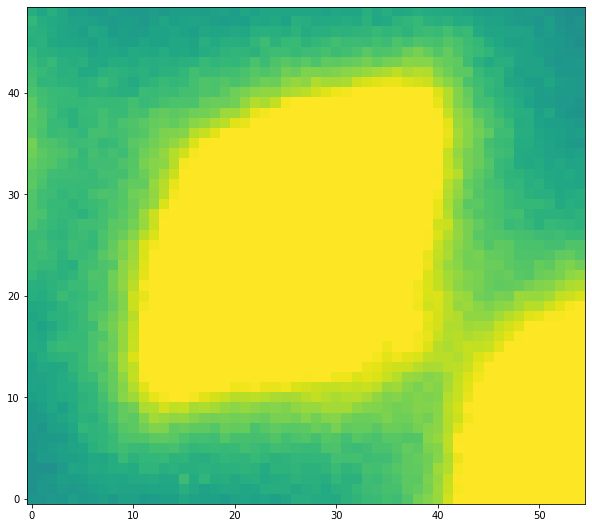

In [35]:
source = cat[6]

# Photutils cutout of the source
# Not to be confused with the cutout we made
plt.imshow(source.data, vmin=vmin, vmax=vmax)
plt.show()

Now we use PetroFit `source_photometry` to compute the curve of growth

7


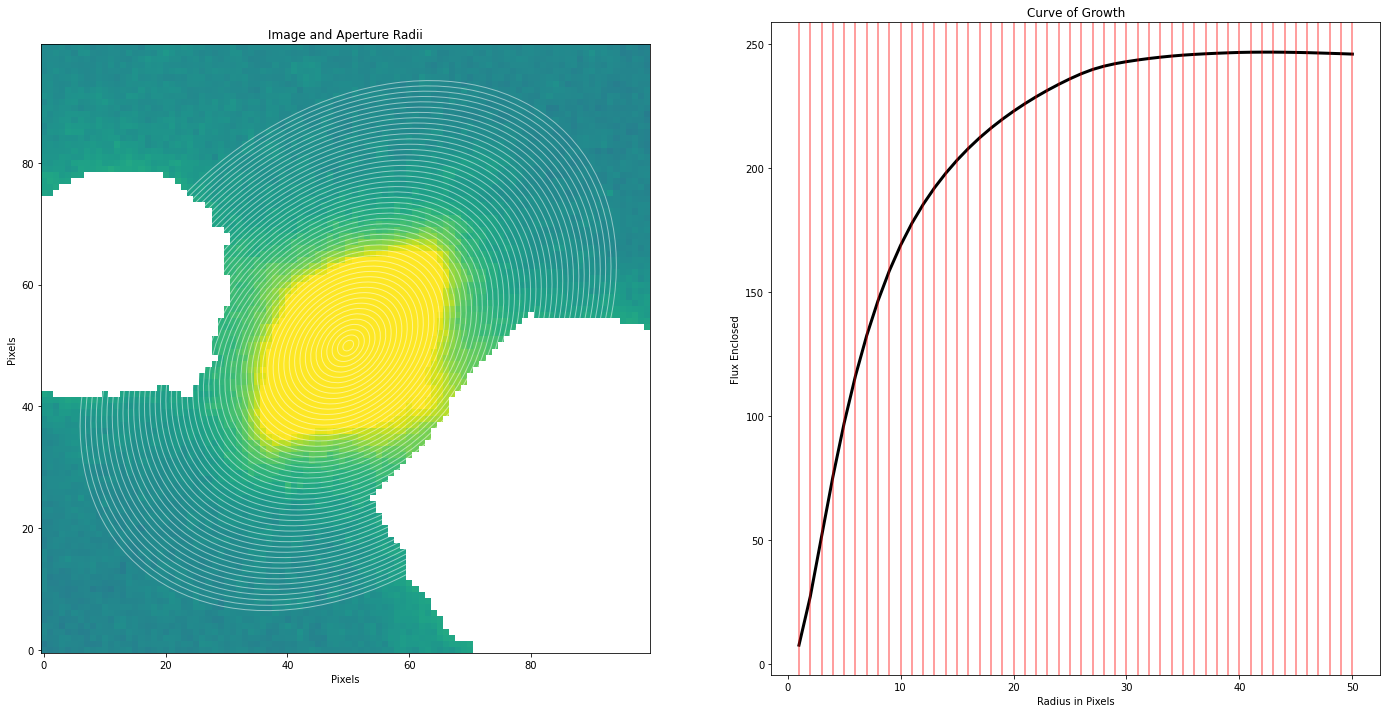

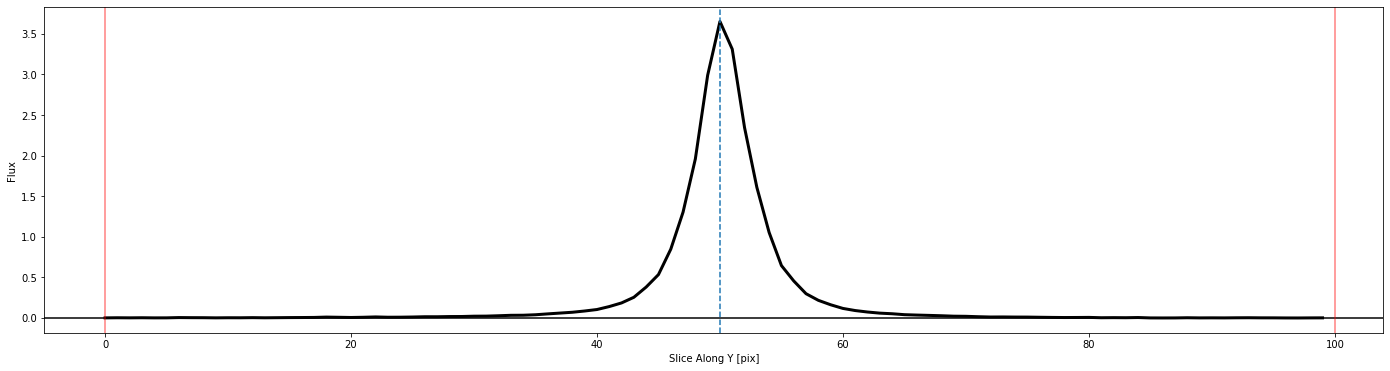

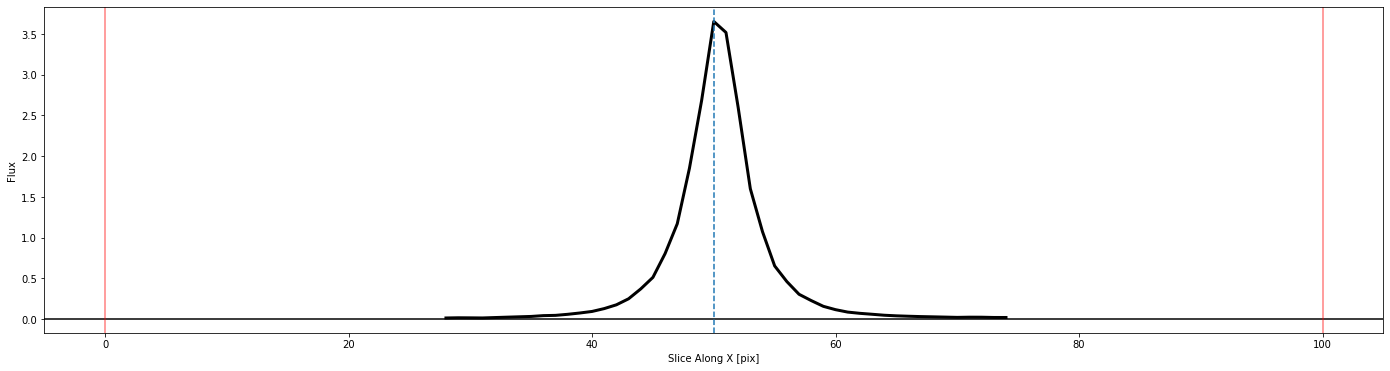

In [36]:
from petrofit.photometry import source_photometry
from petrofit.photometry import make_radius_list

r_list = make_radius_list(
    max_pix=50, # Max pixel to go up to
    n=50 # the number of radii to produce
)

# Photomerty
flux_arr, area_arr, error_arr = source_photometry(

    # Inputs
    source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
    image.data, # Image as 2D array
    segm_deblend, # Deblended segmentation map of image
    r_list, # list of aperture radii

    # Options
    cutout_size=max(r_list)*2, # Cutout out size, set to double the max radius
    bkg_sub=True, # Subtract background
    sigma=3, sigma_type='clip', # Fit a 2D plane to pixels within 3 sigma of the mean
    plot=True, vmax=vmax, vmin=vmin, # Show plot with max and min defined above
)
plt.show()

Now we have a radius list (`r_list`) and a corresponding enclosed flux list (`flux_arr`), we can plot the curve of growth and initialize a `Petrosian` profile

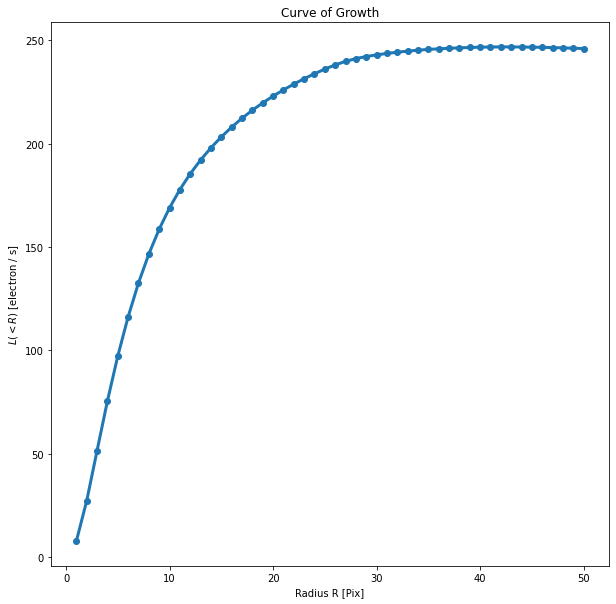

In [37]:
plt.plot(r_list, flux_arr, linewidth=3, marker='o')

plt.title("Curve of Growth")
plt.xlabel("Radius R [Pix]")
plt.ylabel("$L(<R)$ [{}]".format(image.unit))
plt.show()

We now define the `Petrosian` using the curve of growth arrays and inspect various radii:

In [38]:
from petrofit.petrosian import Petrosian

p = Petrosian(r_list, area_arr, flux_arr)

print(p.r_half_light, p.r_total_flux, p.r_petrosian, p.c2080)

6.31126225245049 30.12602520504101 15.063012602520505 3.3277913533762824


The radii can be plotted as follows:

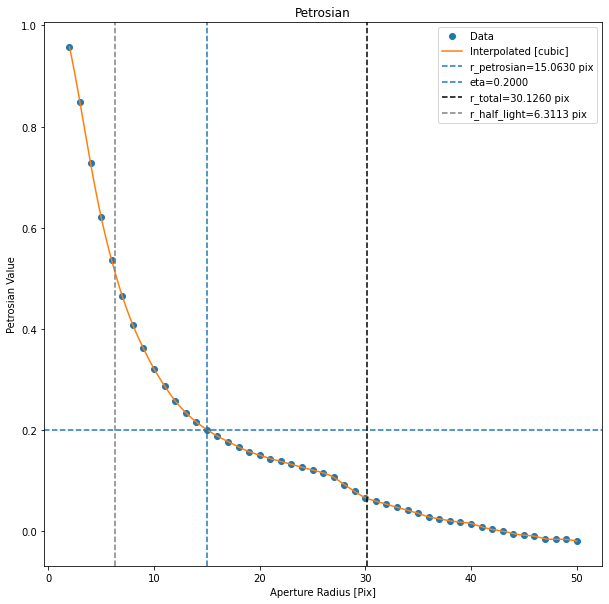

In [39]:
# Plot Petrosian
p.plot(plot_r=True)
plt.show()

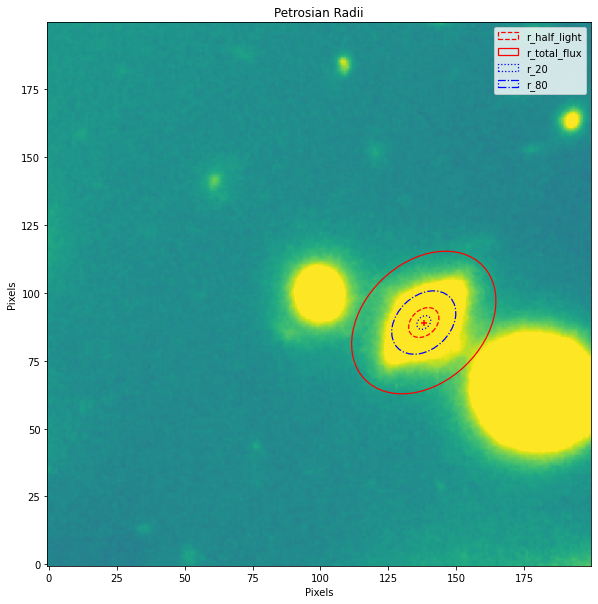

In [40]:
# Plot radii over image 
from petrofit.segmentation import get_source_position, get_source_elong, get_source_theta

# Get shape and pixel location from source
position = get_source_position(source)
elong = get_source_elong(source)
theta = get_source_theta(source)

# Plot radii 
p.imshow(position=position, elong=elong, theta=theta, lw=1.25)

# Plot image 
plt.imshow(image.data, vmax=vmax, vmin=vmin)

plt.title('Petrosian Radii')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.legend()
plt.show()